The aim of this notebook is to improve upon the methods used in notebook 7a.

It contains:
- Loading and writing Sentinel-2 data and WorldCover data into a dataset based on region (no merging needed)
- Testing to see if that dataste was save properly

Note:
- The dataset is relatively small, so I can test it easily
- This notebook Works with 8b, **not 8a** as they use incompatible data saving/loading techniques



In [2]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import numpy as np
# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools
import s3fs
import boto3

# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [3]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


In [4]:
import planetary_computer
from pystac_client import Client as PClient
import odc.stac
import io
import warnings
warnings.filterwarnings('ignore')
from odc.geo.geobox import GeoBox
from odc.geo.geom import box as odc_box
import time as _time
from pystac_client.exceptions import APIError
from dataclasses import dataclass
from typing import Dict, List, Tuple

print("Data Loader Libraries Imported Successfully")

Data Loader Libraries Imported Successfully


In [5]:
import icechunk as ic
from icechunk.xarray import to_icechunk
print("Helper libraries successfully imported")

Helper libraries successfully imported


# Dask Setup

In [6]:
gateway = Gateway()
options = gateway.cluster_options()
# To get GPUs you must specify
#options.cuda_worker = True
clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)

NUM_WORKERS = 2
cluster.scale(NUM_WORKERS)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)

Connecting to existing cluster: easihub.b31c0b561b514cb8b1edd236b2b897c3
Cluster Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.b31c0b561b514cb8b1edd236b2b897c3/status


In [7]:
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

This implimentation uses `ice-chunk`, if `ice-chunk` is not on your worker image you need to install them.

In [ ]:
client.restart()

print("Installing icechunk (and zarr>=3) on all workers...")
client.run(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

print("Installing icechunk (and zarr>=3) on the Scheduler...")
client.run_on_scheduler(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

print("Installation initiated on both Scheduler and Workers. Now retry the Icechunk build.")

# Data Prep
We will use the s3 bucket spcified linked to my EASI acount for storing the data.

In [8]:
# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
base_prefix = f"{userid}/{project_name}"
s3_base = f"s3://{bucket}/{base_prefix}"

Successfully found configuration for deployment "csiro"


## Data Selection
Here we Specify:
- Regions to Select the data from
- What Label dataset we will be using (in this case World Cover)

In [9]:
@dataclass
class RegionSpec:
    name: str
    bbox: Tuple[float, float, float, float]

@dataclass
class EODataSpec:
    regions: List[RegionSpec]
    seasonal_windows: List[str]
    bands_s2: List[str]          # raw band IDs you load from STAC
    band_names: List[str]        # canonical names in same order as a subset
    band_map: Dict[str, str]     # mapping raw -> canonical
    resolution: int
    output_crs: str
    tile_size: int


In [10]:
#TODO: Change this to file input (JSNO maybe?)

# === CONFIGURATION ===
region_specs = [
    RegionSpec("tasmania_forest_c", [146.5, -42.0, 146.7, -41.8]),
    RegionSpec("tasmania_forest_w", [146.3, -42.0, 146.5, -41.8]),
    RegionSpec("tasmania_forest_e", [146.7, -42.0, 146.9, -41.8]),
    RegionSpec("tasmania_forest_s", [146.5, -42.2, 146.7, -42.0]),
    RegionSpec("vic_agriculture_c", [143.5, -37.0, 143.7, -36.8]),
    RegionSpec("vic_agriculture_w", [143.3, -37.0, 143.5, -36.8]),
    RegionSpec("vic_agriculture_e", [143.7, -37.0, 143.9, -36.8]),
    RegionSpec("vic_agriculture_n", [143.5, -36.8, 143.7, -36.6]),
    RegionSpec("vic_agriculture_s", [143.5, -37.2, 143.7, -37.0]),
    RegionSpec("nsw_coast_c", [150.8, -34.5, 151.0, -34.3]),
    RegionSpec("nsw_coast_n", [150.8, -34.3, 151.0, -34.1]),
    RegionSpec("nsw_coast_s", [150.8, -34.7, 151.0, -34.5]),
    RegionSpec("nsw_coast_w", [150.6, -34.5, 150.8, -34.3]),
    RegionSpec("nsw_coast_e", [151.0, -34.5, 151.2, -34.3]),
    RegionSpec("qld_tropical_c", [145.7, -16.5, 145.9, -16.3]),
    RegionSpec("qld_tropical_n", [145.7, -16.3, 145.9, -16.1]),
    RegionSpec("qld_tropical_s", [145.7, -16.7, 145.9, -16.5]),
    RegionSpec("qld_tropical_w", [145.5, -16.5, 145.7, -16.3]),
    RegionSpec("qld_tropical_e", [145.9, -16.5, 146.1, -16.3]),
    RegionSpec("wa_arid_c", [116.0, -32.0, 116.2, -31.8]),
    RegionSpec("wa_arid_n", [116.0, -31.8, 116.2, -31.6]),
    RegionSpec("wa_arid_s", [116.0, -32.2, 116.2, -32.0]),
    RegionSpec("wa_arid_w", [115.8, -32.0, 116.0, -31.8]),
    RegionSpec("wa_arid_e", [116.2, -32.0, 116.4, -31.8]),
    RegionSpec("sa_mallee_1", [140.5, -34.8, 140.7, -34.6]),
    RegionSpec("sa_mallee_2", [140.7, -34.8, 140.9, -34.6]),
    RegionSpec("nt_savanna_1", [132.0, -14.0, 132.2, -13.8]),
    RegionSpec("nt_savanna_2", [132.2, -14.0, 132.4, -13.8]),
    RegionSpec("qld_inland_pasture_1", [147.0, -25.0, 147.2, -24.8]),
    RegionSpec("qld_inland_pasture_2", [147.2, -25.0, 147.4, -24.8]),
]

spec = EODataSpec(
    regions=region_specs,
    seasonal_windows=[
        "2021-01-01/2021-02-28",
        "2021-06-01/2021-07-31",
        "2021-09-01/2021-10-31",
    ],
    bands_s2=["B02", "B03", "B04", "B8A", "B11", "B12", "SCL"],
    band_names=["blue", "green", "red", "nir", "swir1", "swir2"],
    band_map={
        "B02": "blue",
        "B03": "green",
        "B04": "red",
        "B8A": "nir",
        "B11": "swir1",
        "B12": "swir2",
    },
    resolution=20,
    output_crs="EPSG:3577",
    tile_size=224,
)

catalog = PClient.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

print("Data setup done")

Data setup done


## Processing Individual Locations
In order to scale better, we will break up the datset into specific locations, make a temporary, then combine them into one larger dataset at the end. 
This large dataset will contain:
- Train data
- Validation data
We can do a seperate data call for the test dataset later when evaluating.

The Prithvi model we are using prefers everything in 224x224 patches so we will load in a large patches, break them down into 224x224 and save them into the dataset.

In [11]:


# Refractor tested and working
class RegionSampler:
    def sample_patches(
        self,
        features_region: xr.DataArray,  # (band, time, y, x)
        labels_region: xr.DataArray,    # (y, x)
    ) -> list[xr.Dataset]:
        raise NotImplementedError

class GridRegionSampler(RegionSampler):
    def __init__(self, tile_size: int):
        self.tile_size = tile_size

    def sample_patches(self, features_region, labels_region):
        tile_size = self.tile_size
        ny, nx = features_region.sizes["y"], features_region.sizes["x"]
        ny_tiles = ny // tile_size
        nx_tiles = nx // tile_size

        patches = []
        sample_idx = 0
        for iy in range(ny_tiles):
            for ix in range(nx_tiles):
                ys = slice(iy * tile_size, (iy + 1) * tile_size)
                xs = slice(ix * tile_size, (ix + 1) * tile_size)

                feat_patch = features_region.isel(y=ys, x=xs)
                lab_patch = labels_region.isel(y=ys, x=xs)

                feat_patch = feat_patch.assign_coords(
                    y=np.arange(tile_size),
                    x=np.arange(tile_size),
                )
                lab_patch = lab_patch.assign_coords(
                    y=np.arange(tile_size),
                    x=np.arange(tile_size),
                )

                ds = xr.Dataset(
                    {"features": feat_patch, "labels": lab_patch}
                ).expand_dims(sample=[sample_idx])

                patches.append(ds)
                sample_idx += 1

        return patches



In [12]:
def safe_search_items(catalog, collections, bbox, datetime=None, query=None,
                      max_items=150, retries=3):
    for i in range(retries):
        t0 = _time.time()
        print(f"  STAC search start (try {i+1}/{retries}) "
              f"{collections} {datetime} bbox={bbox}")
        try:
            search = catalog.search(
                collections=collections,
                bbox=bbox,
                datetime=datetime,
                query=query,
                max_items=max_items,
            )
            items = search.item_collection()
            dt = _time.time() - t0
            return items
        except APIError as e:
            dt = _time.time() - t0
            print(f"  STAC search failed after {dt:.1f}s: {e}")
            msg = str(e)
            if "maximum allowed time" in msg and i < retries - 1:
                wait = 2 ** i
                print(f"  STAC timeout, retry {i+1}/{retries} after {wait}s...")
                time.sleep(wait)
                continue
            raise

# --- Region-level geobox and loaders ---

def make_region_geobox(spec: EODataSpec, bbox):
    """
    Full-region GeoBox; patches will be spec.tile_size later via slicing.
    """
    geom_4326 = odc_box(bbox[0], bbox[1], bbox[2], bbox[3], crs="EPSG:4326")
    geom_3577 = geom_4326.to_crs(spec.output_crs)
    return GeoBox.from_bbox(
        geom_3577.boundingbox,
        crs=spec.output_crs,
        resolution=spec.resolution,
    )


def load_region_labels(catalog, spec: EODataSpec, bbox):
    geobox = make_region_geobox(spec, bbox)
    items = safe_search_items(
        catalog=catalog,
        collections=["esa-worldcover"],
        bbox=bbox,
        max_items=25,
    )
    if not items:
        return None, geobox

    ds = odc.stac.load(
        items,
        bands=["map"],
        geobox=geobox,
        chunks={"y": 1024, "x": 1024},
        resampling="nearest",
        fail_on_error=False,
    )
    labels = ds["map"].isel(time=0, drop=True).fillna(255).astype("uint8")
    return labels, geobox


    
def load_region_season(catalog, spec: EODataSpec, bbox, time_range, geobox):
    try:
        items = safe_search_items(
            catalog=catalog,
            collections=["sentinel-2-l2a"],
            bbox=bbox,
            datetime=time_range,
            query={"eo:cloud_cover": {"lt": 90}},
            max_items=100,
        )
    except APIError as e:
        print(f"  [season {time_range}] STAC search failed: {e}")
        return None

    if not items:
        return None

    ds = odc.stac.load(
        items,
        bands=spec.bands_s2,
        geobox=geobox,
        chunks={"y": 1024, "x": 1024},
        fail_on_error=False,
    )
    if ds.sizes.get("time", 0) == 0:
        return None

    if "SCL" in ds:
        qa = ds["SCL"]
        valid = ((qa == 4) | (qa == 5) | (qa == 6) |
                 (qa == 7) | (qa == 2) | (qa == 11))
        masked = ds.where(valid)
        comp = masked.median(dim="time")
        comp = comp.fillna(masked.min(dim="time")).fillna(0)
    else:
        comp = ds.median(dim="time").fillna(0)

    # Now use the spec-driven band selection/rename
    raw_band_ids = list(spec.band_map.keys())
    comp = comp[raw_band_ids]
    comp = comp.rename(spec.band_map).astype("uint16")
    return comp


def region_to_patches(
    catalog,
    spec: EODataSpec,
    region: RegionSpec,
    sampler: RegionSampler,
    ):
    bbox = region.bbox

    labels_region, geobox = load_region_labels(catalog, spec, bbox)
    if labels_region is None:
        print(f"  No labels for {region.name}, skipping.")
        return []

    comps = []
    for t in spec.seasonal_windows:
        comp = load_region_season(catalog, spec, bbox, t, geobox)
        if comp is None:
            print(f"  Skipping {region.name} for window {t} (no data / STAC error)")
            return []
        comps.append(comp)

    features_region = xr.concat(comps, dim="time")
    features_region = features_region.to_array("band").transpose("band", "time", "y", "x")

    return sampler.sample_patches(features_region, labels_region)


# --- Per-region write to temporary Zarrs ---
class STACIceChunkBuilder:
    def __init__(
        self,
        catalog,
        bucket: str,
        base_prefix: str,
        dataset_name: str,
        spec: EODataSpec,
        sampler: RegionSampler | None = None,
        region: str | None = "ap-southeast-2",
    ):
        self.catalog = catalog
        self.spec = spec
        self.bucket = bucket
        self.base_prefix = base_prefix
        self.dataset_name = dataset_name
        self.sampler = sampler or GridRegionSampler(tile_size=spec.tile_size)

        # Each dataset gets its own clean S3 prefix for the Icechunk repo
        self.repo_prefix = f"{base_prefix}/{dataset_name}-icechunk"
        session = boto3.session.Session()
        # Configure Icechunk S3 storage and repo once in __init__
        self.storage = ic.s3_storage(
            bucket=self.bucket,
            prefix=self.repo_prefix,
            region=region,
            from_env=True,   # uses your usual AWS creds / role
        )
        # open_or_create is the recommended pattern for scripts rerun many times
        self.repo = ic.Repository.open_or_create(self.storage)  # [web:1][web:64]

        

    @property
    def s3_base(self) -> str:
        return f"s3://{self.bucket}/{self.base_prefix}"
    
    def cleanup_repo(self):
        fs = s3fs.S3FileSystem(anon=False)
        path = f"s3://{self.bucket}/{self.repo_prefix}"
        print("Deleting Icechunk repo prefix:", path)
        fs.rm(path, recursive=True)
        
    # thin wrapper around your existing function-based helper
    def region_to_patches(self, region: RegionSpec):
        return region_to_patches(self.catalog, self.spec, region, self.sampler)


    def build(self, branch: str = "main", resume: bool = True) -> str:
        """
        Incrementally build a single Icechunk-backed dataset on S3.
    
        If resume=True:
          - Detect an existing dataset on this branch.
          - Skip regions already written (tracked via 'regions_done').
          - Append only missing regions along 'sample'.
    
        If resume=False:
          - Overwrite from scratch (first write uses mode='w').
    
        Returns the final snapshot_id string for this build.
        """
        total_samples = 0
        last_snapshot_id: str | None = None
        regions_done: set[str] = set()
    
        if resume:
            try:
                ro_session = self.repo.readonly_session(branch)
                ds_existing = xr.open_zarr(
                    ro_session.store,
                    consolidated=False,   # no engine kw here
                )
            except Exception as e:
                raise RuntimeError(
                    f"resume=True but no readable dataset found on branch '{branch}'. "
                    "Run once with resume=False (fresh build) or clean the repo prefix."
                ) from e
            else:
                total_samples = int(ds_existing.sizes.get("sample", 0) or 0)
                regions_done = set(ds_existing.attrs.get("regions_done", []))
                print(
                    f"[resume] Found existing dataset on '{branch}': "
                    f"{total_samples} samples, {len(regions_done)} regions_done."
                )
            first_region = False
        else:
            print(
                f"resume=False: will overwrite any existing dataset on branch '{branch}' "
                f"(first write uses mode='w')."
            )
            first_region = True
    
        for region in self.spec.regions:
            if resume and region.name in regions_done:
                print(f"  Region {region.name} already present, skipping.")
                continue
    
            print(f"\n=== Building patches for {region.name} ===")
            try:
                patches = self.region_to_patches(region)
            except APIError as e:
                print(f"  Skipping {region.name} due to STAC API error: {e}")
                continue
    
            if not patches:
                print(f"  No patches for {region.name}, skipping.")
                continue
    
            ds_region = xr.concat(patches, dim="sample")

            # ---- TRAINING-OPTIMIZED VIEW: drop 'band' variable but keep names ----
            # Will help later
            if "band" in ds_region.coords:
                band_names = ds_region.coords["band"].values.tolist()  # ['blue','green',...]
                ds_region = ds_region.drop_vars("band")                # remove object coord var
                ds_region.attrs["bands"] = band_names                  # keep mapping in attrs
            else:
                # Fallback: still set bands from spec if coord missing
                ds_region.attrs["bands"] = self.spec.band_names

            
            ds_region = ds_region.chunk({
                "sample": 8,
                "time": -1,
                "band": -1,
                "y": self.spec.tile_size,
                "x": self.spec.tile_size,
            })
            ds_region.attrs["n_time_steps"] = len(self.spec.seasonal_windows)
            ds_region.attrs["bands"] = self.spec.band_names
    
            print(f"  Writing {ds_region.sizes['sample']} samples from {region.name}")
    
            # New writable session for this write [web:6]
            session = self.repo.writable_session(branch)
    
            if first_region:
                # Only ever used on a true fresh build (resume=False) [web:6][web:55]
                to_icechunk(ds_region, session, mode="w")
                first_region = False
            else:
                # Append along 'sample' with automatic chunk alignment [web:6][web:55]
                to_icechunk(
                    ds_region,
                    session,
                    append_dim="sample",
                    align_chunks=True,
                )
    
            # Update regions_done within this transaction
            regions_done.add(region.name)
            root = zarr.open_group(session.store, mode="r+")
            root.attrs["regions_done"] = list(regions_done)
    
            last_snapshot_id = session.commit(
                f"append {ds_region.sizes['sample']} samples from {region.name}"
            )
            total_samples += ds_region.sizes["sample"]
    
        if last_snapshot_id is None:
            if resume:
                # Nothing new to write; dataset already complete for this spec
                print(
                    "[resume] No new regions were written; all regions are already present. "
                    "Returning current branch tip."
                )
                # Return the current branch tip snapshot
                ro_session = self.repo.readonly_session(branch)
                return ro_session.snapshot_id  # or whatever your caller expects
            else:
                # Fresh build with no data is probably a real problem
                raise RuntimeError("No regions produced data; nothing was written.")
        print(f"[Done] Icechunk repo s3://{self.bucket}/{self.repo_prefix}")
        print(f"Total samples (this branch view): {total_samples}")
        print(f"Final snapshot id: {last_snapshot_id}")
        return last_snapshot_id

## Combining the Datasets
Once we have all the data saved and loaded we can combine them into once cmplete dataset

In [14]:
print("Building incremental Icechunk dataset...")

sampler = GridRegionSampler(tile_size=224)

# Choose a logical dataset name (no need for .zarr suffix)
dataset_name = "training_dataset_v4"

builder = STACIceChunkBuilder(
    catalog=catalog,
    bucket=bucket,
    base_prefix=base_prefix,
    dataset_name=dataset_name,
    spec=spec,
    sampler=sampler,
)

snapshot_id = builder.build(branch="main", resume=True)
print("Snapshot ID:", snapshot_id)

# For later use in training:
print("Repo prefix:", builder.repo_prefix)   # e.g. f"{base_prefix}/{dataset_name}-icechunk"

Building incremental Icechunk dataset...
[resume] Found existing dataset on 'main': 627 samples, 30 regions_done.
  Region tasmania_forest_c already present, skipping.
  Region tasmania_forest_w already present, skipping.
  Region tasmania_forest_e already present, skipping.
  Region tasmania_forest_s already present, skipping.
  Region vic_agriculture_c already present, skipping.
  Region vic_agriculture_w already present, skipping.
  Region vic_agriculture_e already present, skipping.
  Region vic_agriculture_n already present, skipping.
  Region vic_agriculture_s already present, skipping.
  Region nsw_coast_c already present, skipping.
  Region nsw_coast_n already present, skipping.
  Region nsw_coast_s already present, skipping.
  Region nsw_coast_w already present, skipping.
  Region nsw_coast_e already present, skipping.
  Region qld_tropical_c already present, skipping.
  Region qld_tropical_n already present, skipping.
  Region qld_tropical_s already present, skipping.
  Regio

#### Optional Step (1)
If you just want to delete everything you can so doing this

In [ ]:

fs = s3fs.S3FileSystem(anon=False)

# Full S3 path to the Icechunk repo prefix
icechunk_prefix = f"s3://{bucket}/{builder.repo_prefix}"

print("Deleting Icechunk repo prefix:", icechunk_prefix)
fs.rm(icechunk_prefix, recursive=True)

#### Optional Step (2)
You can check the data format and if everything was saved correctly by graphing a few samples locally.
You should check:
- Demensions of the dataset (sample: 627, band: 6, time: 3, y: 224, x: 224)
  - bands, x and y should match the model input you are using (For prithvi 6 bands, and 224x224 patches)
- Label Dimensions and Values
  - Dimensions should match the 224x224 patches
  - Values should not contain NaN and be multiples of 10 from 10 to 100 or 95
  - This is also a sanity check to see if your labels line up with the ESI patches spatially 



Target Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v3.zarr
<xarray.DataArray 'features' (sample: 627, band: 6, time: 3, y: 224, x: 224)> Size: 1GB
dask.array<open_dataset-features, shape=(627, 6, 3, 224, 224), dtype=uint16, chunksize=(8, 6, 3, 224, 224), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 48B 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'
  * sample       (sample) int64 5kB 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
    spatial_ref  int32 4B ...
  * x            (x) int64 2kB 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223
  * y            (y) int64 2kB 0 1 2 3 4 5 6 7 ... 217 218 219 220 221 222 223
Dimensions without coordinates: time
Dataset loaded. Dimensions:
  Samples (N): 627
  Time Steps (T): 3
  Spatial (Y, X): 224, 224
  Bands: ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
DEBUG: Sample 0 unique label values: [10 30 60 80 90]
Processing Sample 0...

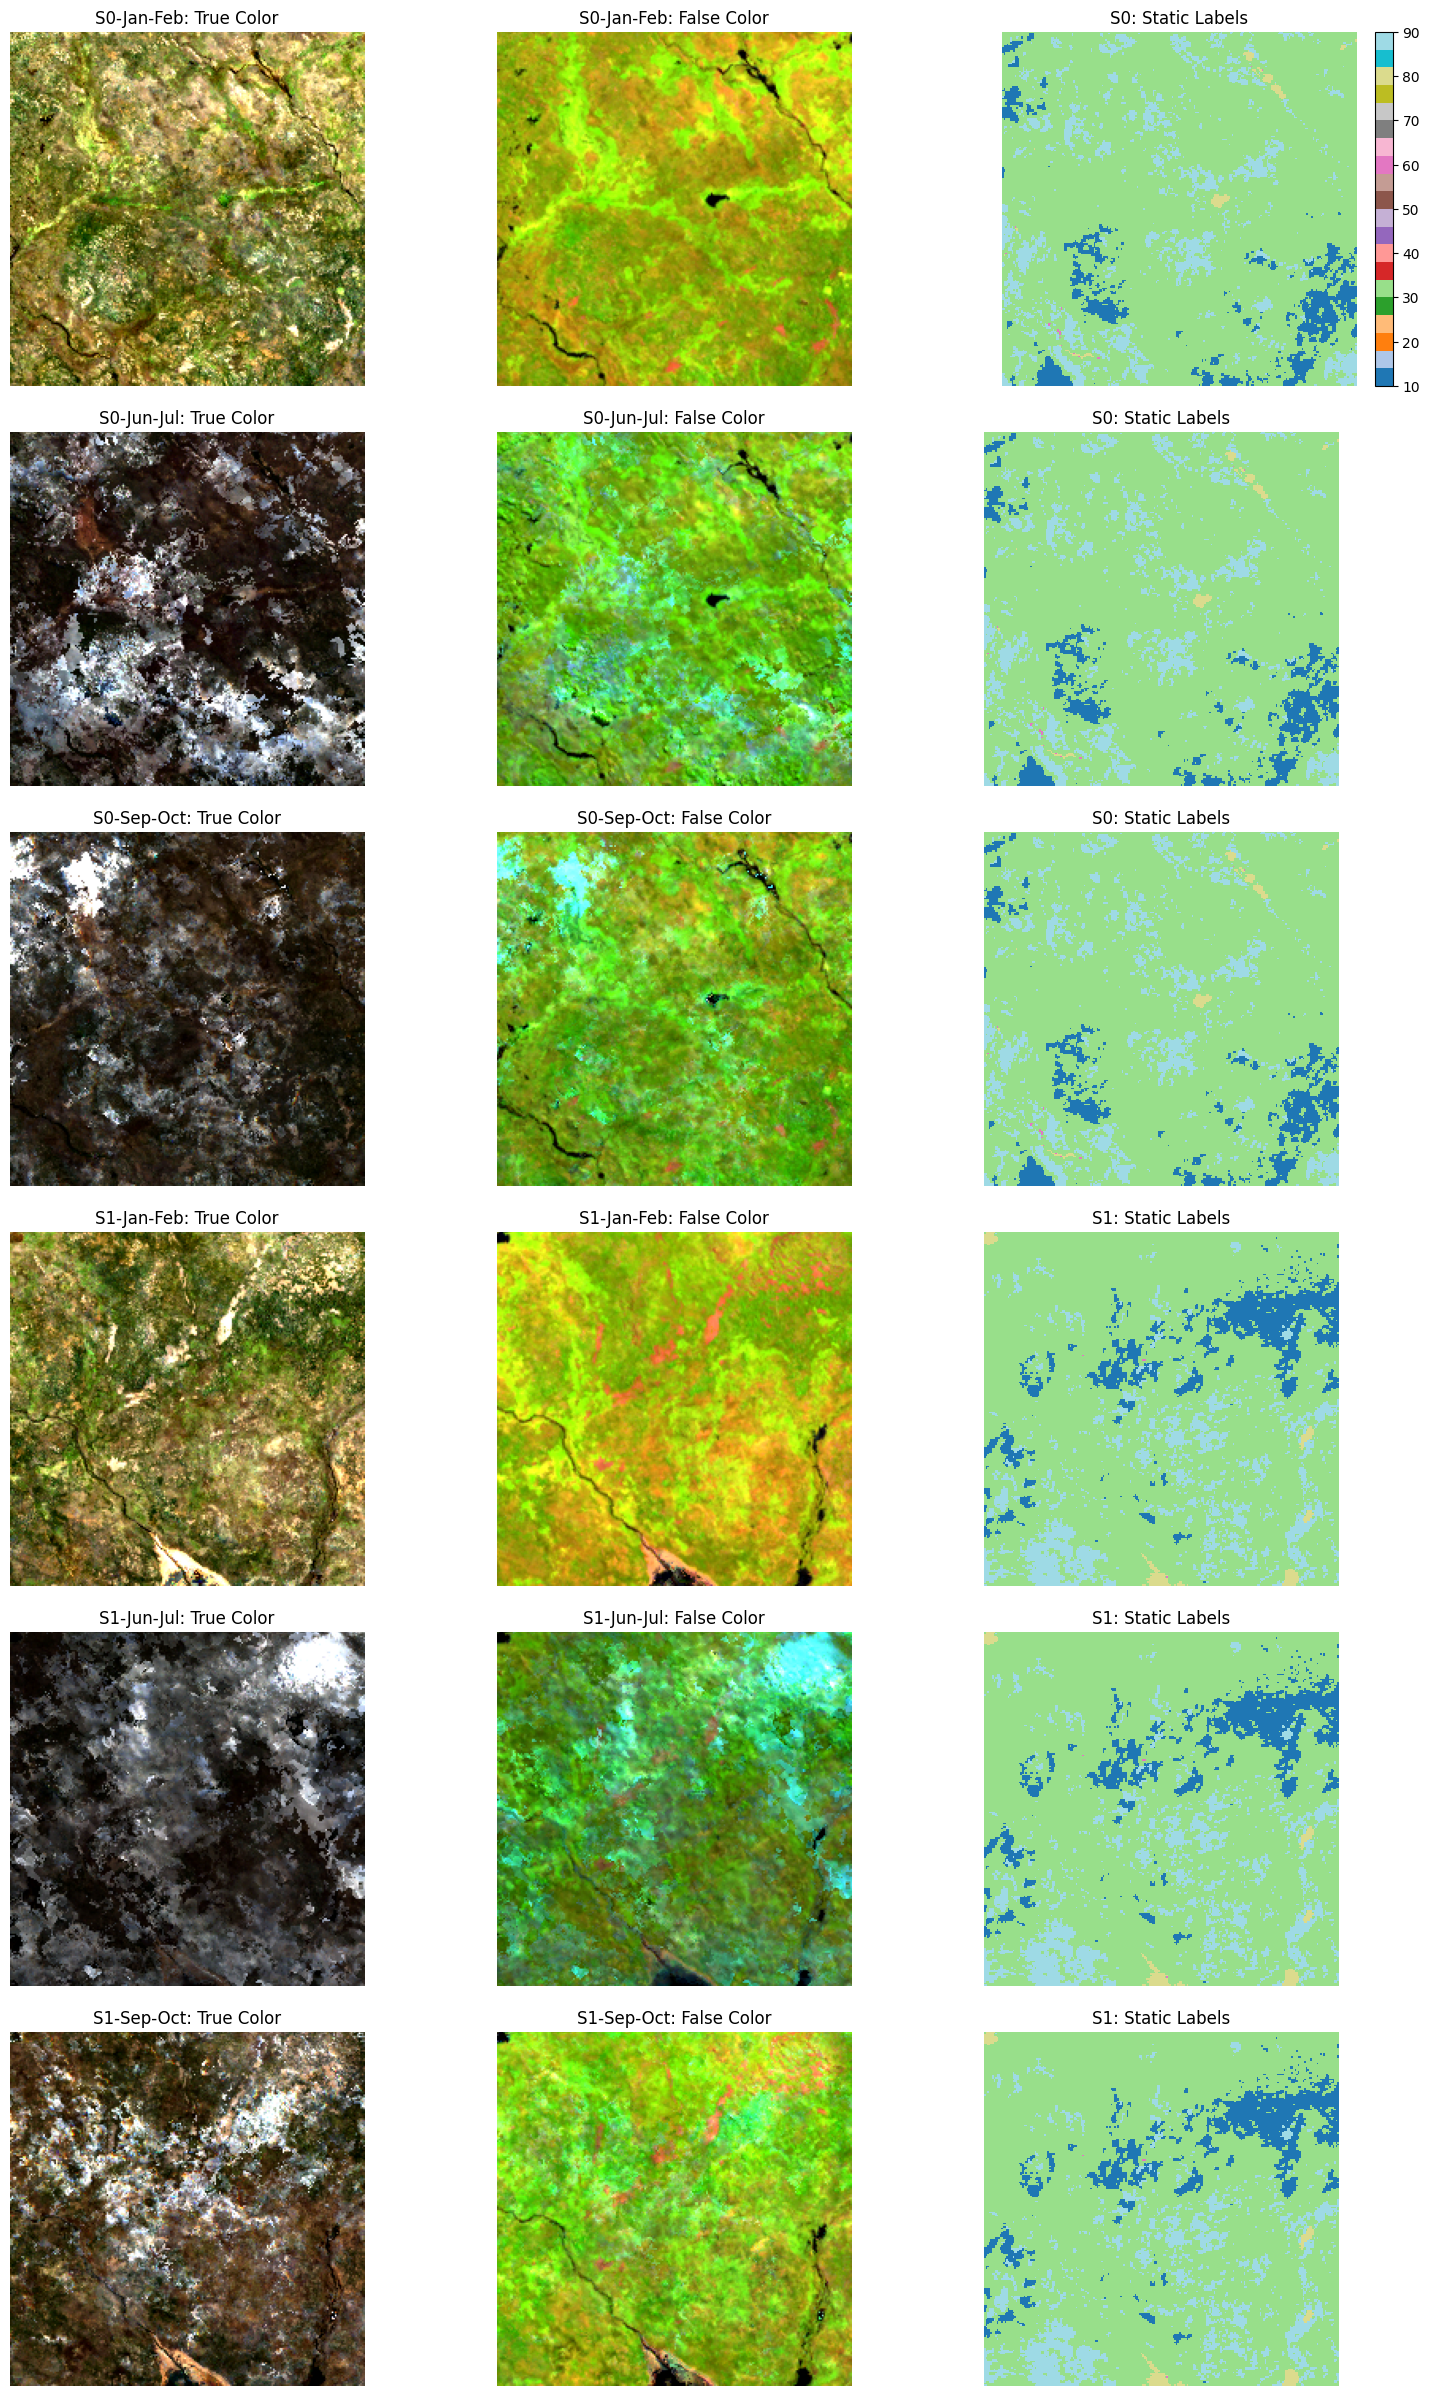

In [41]:
# Basic testing script to see that saving the data worked, TODO: use hvplot for better efficiency


easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_v4"
repo_prefix = f"{userid}/{project_name}/{dataset_name}-icechunk"

# Region (same as in the builder)
session_aws = boto3.session.Session()
region = session_aws.region_name or "ap-southeast-2"

print("⏳ Verifying Icechunk-backed dataset...")
try:
    storage = ic.s3_storage(
        bucket=bucket,
        prefix=repo_prefix,
        region=region,
        from_env=True,
    )
    repo = ic.Repository.open(storage)

    # Just use the tip of main for a quick check
    session = repo.readonly_session(branch="main")

    # session.store is a normal Zarr v3 store
    ds = xr.open_zarr(session.store, consolidated=False, chunks={})
except Exception as e:
    print(f"⚠️ Error loading Icechunk dataset: {e}")
    raise


features = ds["features"]
labels = ds["labels"]
print(features)

num_samples = ds.sizes.get('sample')
n_time_steps = ds.sizes.get('time')

if num_samples is None or n_time_steps != 3:
    print("\n❌ CRITICAL ERROR: The loaded Zarr file still does NOT contain the 'sample' dimension or the correct 'time' size (3).")
    print("Please re-run the data generation pipeline to ensure the correct multi-sample Zarr is saved before proceeding.")
    # Exit or raise an exception to prevent training on bad data
    raise KeyError("Loaded Zarr file is structurally incorrect. Expected dimensions 'sample' and 'time' size 3.")

print(f"Dataset loaded. Dimensions:")
print(f"  Samples (N): {num_samples}")
print(f"  Time Steps (T): {n_time_steps}")
print(f"  Spatial (Y, X): {features.sizes['y']}, {features.sizes['x']}")

# --- 2. Config & Helpers ---
# Band names are now coordinates thanks to the saving logic
band_names = list(ds.attrs["bands"])
print(f"  Bands: {band_names}")
band_index = {name: i for i, name in enumerate(band_names)}
def get_rgb(data_array, bands_list):
    """
    Extracts bands for RGB from a DataArray, assuming the order (B, T, Y, X).
    """
    stack = []
    
    # 1. Extraction (Still the same, but now operating on the first dim B)
    for b in bands_list:
        idx = band_index[b]              # get index for this band name
        band_data = data_array.isel(band=idx)  # (time, y, x); no .sel(band=b)
        stack.append(band_data)
        
    # Stack along a new 'color' dimension. Output shape: (Color, T, Y, X)
    img = xr.concat(stack, dim="color").values.astype('float32')

    # 2. DN Scaling Correction (Scale from uint16 DNs to 0.0-1.0 float range)
    img = img / 10000.0
    img = np.nan_to_num(img, nan=0.0)
    
    # 3. Final Transpose: (Color, T, Y, X) -> (T, Y, X, Color) for plotting
    # Plotting requires (Time, Height, Width, Color)
    img = np.transpose(img, (1, 2, 3, 0)) 
    
    # Check if all images are empty (all zeros)
    if img.max() == 0:
        return None 
        
    # Contrast Stretch - apply stretching to each time step independently
    # The loop is now simpler as 'img' is already (T, Y, X, Color)
    for t in range(img.shape[0]):
        time_slice = img[t, :, :, :]
        valid_pixels = time_slice[time_slice > 0]
        
        if valid_pixels.size > 0:
            p2, p98 = np.percentile(valid_pixels, (2, 98))
            if p98 > p2:
                img[t, :, :, :] = (time_slice - p2) / (p98 - p2)
                        
    return np.clip(img, 0, 1)

# --- 3. Dynamic Plotting Loop ---

# Iterate over SAMPLES, not time steps.
rows = num_samples * n_time_steps 
cols = 3 # RGB, False Color, Labels

plt.figure(figsize=(15, 4 * rows))

plot_idx = 1
season_names = ["Jan-Feb", "Jun-Jul", "Sep-Oct"] # Names from seasonal_windows

for s in range(2):
    # Select a single sample and compute its features and label.
    # .compute() here will read data off S3, potentially distributively if
    # the dask client is still running, which is appropriate for verification.
    sample_features = features.isel(sample=s).compute()
    sample_label = labels.isel(sample=s).compute()
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    # 🚨 DEBUGGING STEP: Print unique values
    unique_vals = np.unique(label_np)
    print(f"DEBUG: Sample {s} unique label values: {unique_vals}")
    # ----------------------------------------
    # Check for valid data across all time steps in this sample
    # (Checking the max of the entire sample array is a quick check)
    if sample_features.values.max() == 0:
        print(f"⚠️ Sample {s} appears empty (all zeros). Skipping.")
        continue

    # Process all time steps for this sample
    print(f"Processing Sample {s}...")

    # Generate Images for all time steps at once
    # rgb_stack: (T, Y, X, Color)
    rgb_stack = get_rgb(sample_features, ['red', 'green', 'blue'])
    fc_stack  = get_rgb(sample_features, ['swir1', 'nir', 'red'])

    if rgb_stack is None:
        print(f"⚠️ Skipping Sample {s}: RGB stack failed.")
        continue
    
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    for t in range(n_time_steps):
        time_name = season_names[t] if t < len(season_names) else f"Time {t}"
        
        # Plot RGB
        ax1 = plt.subplot(rows, cols, plot_idx)
        ax1.imshow(rgb_stack[t, :, :, :])
        ax1.set_title(f"S{s}-{time_name}: True Color")
        ax1.axis('off')
        plot_idx += 1

        # Plot False Color
        ax2 = plt.subplot(rows, cols, plot_idx)
        ax2.imshow(fc_stack[t, :, :, :])
        ax2.set_title(f"S{s}-{time_name}: False Color")
        ax2.axis('off')
        plot_idx += 1

        # Plot Labels (Only plot on the last column, which should be the same for all time steps)
        ax3 = plt.subplot(rows, cols, plot_idx)
        
        # The labels (WorldCover) are 2D (Y, X), but we repeat the plot for each time step for alignment.
        # Mask out background (0) and nodata (255) for better visualization.
        masked_lbl = np.ma.masked_where(label_np == 255, label_np)
        
        # We need a new colormap instance for consistency if plotting multiple times
        im = ax3.imshow(masked_lbl, cmap='tab20', interpolation='nearest')
        
        # Add colorbar only once for the entire set of label plots (e.g., first time step of the first sample)
        if s == 0 and t == 0: 
            plt.colorbar(im, fraction=0.046, pad=0.04)
            
        # Title only needs to be "Labels" once, or be more specific
        ax3.set_title(f"S{s}: Static Labels")
        ax3.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.show()

# Test Datasets
We can also do the same thing to make a test dataset. It is easier to have the dataset seperate as we won't need it during training.

In [15]:
test_region_specs = [
    # Tasmania forest – shift east and slightly south
    RegionSpec("test_tasmania_forest_e2", [147.1, -42.3, 147.3, -42.1]),

    # Victorian agriculture – shift east and slightly north
    RegionSpec("test_vic_agriculture_e2", [144.1, -36.7, 144.3, -36.5]),

    # NSW coast – shift north along the coast
    RegionSpec("test_nsw_coast_n2", [151.4, -33.9, 151.6, -33.7]),

    # QLD tropical – shift east
    RegionSpec("test_qld_tropical_e2", [146.3, -16.5, 146.5, -16.3]),

    # WA arid – shift east and south
    RegionSpec("test_wa_arid_se2", [116.8, -32.4, 117.0, -32.2]),
]


test_spec = EODataSpec(
    regions=test_region_specs,
    seasonal_windows=spec.seasonal_windows,
    bands_s2=spec.bands_s2,
    band_names=spec.band_names,
    band_map=spec.band_map,
    resolution=spec.resolution,
    output_crs=spec.output_crs,
    tile_size=spec.tile_size,
)

test_builder = STACIceChunkBuilder(
    catalog=catalog,
    bucket=bucket,
    base_prefix=base_prefix,
    dataset_name="training_dataset_v4_test",
    spec=test_spec,
    sampler=sampler,
)

test_snapshot_id = test_builder.build(branch="main", resume=True)
test_repo_prefix = test_builder.repo_prefix
print("Test Snapshot_id: " + test_snapshot_id)
print("Test Repo Prefix: " + test_repo_prefix)

[resume] Found existing dataset on 'main': 105 samples, 5 regions_done.
  Region test_tasmania_forest_e2 already present, skipping.
  Region test_vic_agriculture_e2 already present, skipping.
  Region test_nsw_coast_n2 already present, skipping.
  Region test_qld_tropical_e2 already present, skipping.
  Region test_wa_arid_se2 already present, skipping.
[resume] No new regions were written; all regions are already present. Returning current branch tip.
Test Snapshot_id: CGQQE6C547RPKBTB1CFG
Test Repo Prefix: AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v4_test-icechunk


# Be a good Dask user and close your cluster when you are done

In [18]:
client.close()
cluster.shutdown()